In [7]:
import numpy as np
from function import *
import matplotlib.pyplot as plt
from itertools import product

speed_uav =30
speed_ugv =10
survey_time = 1/6
waypoints = [(12, 50), (20, 25), (19, 36)]
plan_output = "0 -> 2 -> 1 -> 0"
radii = [2,3,4]


In [8]:
def compute_ordered_points(plan_output, waypoints):
    ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
    ordered_points.append(ordered_points[0])
    return ordered_points

def initialize_plot(ordered_points):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(*zip(*ordered_points))
    return fig, ax

def compute_paths_for_radius(ordered_points, radius_combination, speed_ugv, speed_uav, survey_time):
    UGV_outer_path = [ordered_points[0]]
    UGV_path = [ordered_points[0]]
    UAV_path = []
    # UAV_distances = []
    UGV_inter_distances = []
    
    # Main logic to compute paths based on radius_combination
    # This is a placeholder for now. We'll populate this in the next steps.
    
    return UGV_path, UAV_path, UGV_outer_path, UGV_inter_distances

def visualize_paths(ax, ordered_points, UGV_path, UAV_path, UGV_outer_path):
    # Placeholder for visualization logic. We'll populate this in the next steps.
    pass

def compute_non_overlapping_pairwise_distances(path):
    """Compute the distances between each non-overlapping pair of points in the given path."""
    return [compute_distance(path[i], path[i+1]) for i in range(0, len(path) - 1, 2)]
    
def compute_tripwise_distances(path):
    """Compute the distances for each set of three points in the given path."""
    distances = []
    for i in range(0, len(path) - 2, 3):
        distance_trip = compute_distance(path[i], path[i+1]) + compute_distance(path[i+1], path[i+2])
        distances.append(distance_trip)
    return distances

def are_circles_overlapping(c1, r1, c2, r2):
    """
    Check if two circles are overlapping.
    
    Parameters:
    - c1, c2: Tuples representing the centers of the circles (x, y)
    - r1, r2: Radii of the circles
    
    Returns:
    - True if the circles overlap, False otherwise
    """
    
    d = math.sqrt((c2[0] - c1[0])**2 + (c2[1] - c1[1])**2)
    return d < (r1 + r2)


In [9]:
def compute_paths_for_radius(ordered_points, radius_combination, speed_ugv, speed_uav, survey_time):
    UGV_outer_path = [ordered_points[0]]
    UGV_path = [ordered_points[0]]
    UAV_path = []
    UAV_distances = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone= []
    chord_end = None
    
    
    chord_end_previous = None
    overlap_with_previous = False
    
    for i, point in enumerate(ordered_points[:-1]):
        current_radius = radius_combination[i % len(radius_combination)]
        
        # Exclude the start and end points from circles
        if 0 < i < len(ordered_points) - 2:
            # calculate angle and chords for the current waypoint
            angle = angle_between_points(ordered_points[i-1], ordered_points[i])
            nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
            chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
            chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
            
            # Check for overlapping circles
            if chord_end_previous and are_circles_overlapping(ordered_points[i-1], current_radius, ordered_points[i], current_radius):
                overlap_with_previous = True
            else:
                overlap_with_previous = False
            
            if overlap_with_previous:
                # Handle overlapping circles by adjusting UGV path
                UGV_outer_path.append(chord_start)
                UGV_outer_path.append(chord_end)
                chord_end_previous = chord_end
                continue
            
            # ... [rest of the code to calculate meeting point, UAV path, etc.]
             # calculate meeting point
            final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
                ordered_points[i], current_radius, chord_start, chord_end, 
                speed_ugv, speed_uav, survey_time
            )
            UGVD_inter_without_drone.append(compute_distance(chord_start,final_meeting_point))
            UGVD_inter_with_drone.append(compute_distance(final_meeting_point,chord_end))
            # print(f"'At point {i},Path of UGV without Drone:',{UGVD_inter_without_drone:.2f}")           
            # print(f"'At point {i},Path of UGV with Drone:',{UGVD_inter_with_drone:.2f}")

            UGV_outer_path.append(chord_start)
            
            UAV_path.extend([chord_start, ordered_points[i], final_meeting_point])
            UAV_distance_segment = sum(np.linalg.norm(np.array(UAV_path[j]) - np.array(UAV_path[j+1])) 
                                      for j in range(len(UAV_path) - 1))
            # UGV_inter_distance_segment = np.linalg.norm(np.array(chord_start) - np.array(final_meeting_point))
            
            # UAV_distances.append(UAV_distance_segment)
            # UGV_inter_distances.append(UGV_inter_distance_segment)
            UGV_path.append(final_meeting_point)
            
            chord_end_previous = chord_end
            # Connect the last meeting point to the next chord start
            if i > 0 and chord_end:
                UGV_outer_path.append(chord_end)
            # Update the chord_end_previous value
    # Add the last chord_end and the endpoints:
    if chord_end:
        # UGV_outer_path.append(chord_end)
        # UGV_outer_path.append(chord_end)
        UGV_outer_path.append(ordered_points[-1])
    
   
    UGV_path.append(ordered_points[-1])
            

    # ... [rest of the code]

    return UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone


In [24]:
def compute_paths_for_radius(ordered_points, radius_combination, speed_ugv, speed_uav, survey_time):
    UGV_outer_path = [ordered_points[0]]
    UGV_path = [ordered_points[0]]
    UAV_path = []
    UAV_distances = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone= []
    chord_end = None
    
    for i, point in enumerate(ordered_points[:-1]):
        current_radius = radius_combination[i % len(radius_combination)]
        
        # Exclude the start and end points from circles
        if 0 < i < len(ordered_points) - 2:
            # calculate angle and chords for the current waypoint
            angle = angle_between_points(ordered_points[i-1], ordered_points[i])
            nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
            chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
            chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
            
            # calculate meeting point
            final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
                ordered_points[i], current_radius, chord_start, chord_end, 
                speed_ugv, speed_uav, survey_time
            )
            UGVD_inter_without_drone.append(compute_distance(chord_start,final_meeting_point))
            UGVD_inter_with_drone.append(compute_distance(final_meeting_point,chord_end))
            # print(f"'At point {i},Path of UGV without Drone:',{UGVD_inter_without_drone:.2f}")           
            # print(f"'At point {i},Path of UGV with Drone:',{UGVD_inter_with_drone:.2f}")

            UGV_outer_path.append(chord_start)
            
            UAV_path.extend([chord_start, ordered_points[i], final_meeting_point])
            UAV_distance_segment = sum(np.linalg.norm(np.array(UAV_path[j]) - np.array(UAV_path[j+1])) 
                                      for j in range(len(UAV_path) - 1))
            # UGV_inter_distance_segment = np.linalg.norm(np.array(chord_start) - np.array(final_meeting_point))
            
            # UAV_distances.append(UAV_distance_segment)
            # UGV_inter_distances.append(UGV_inter_distance_segment)
            UGV_path.append(final_meeting_point)
            
            # Connect the last meeting point to the next chord start
            if i > 0 and chord_end:
                UGV_outer_path.append(chord_end)
                
    # Add the last chord_end and the endpoints:
    if chord_end:
        # UGV_outer_path.append(chord_end)
        # UGV_outer_path.append(chord_end)
        UGV_outer_path.append(ordered_points[-1])
    
   
    UGV_path.append(ordered_points[-1])
        
    return UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone,UGVD_inter_with_drone


In [10]:
def visualize_paths(ax, ordered_points, UGV_path, UAV_path, UGV_outer_path, radius_combination):
    for i, point in enumerate(ordered_points[:-1]):
        ax.annotate(i, (point[0] + 0.5, point[1] + 0.5))
        
        if 0 < i < len(ordered_points) - 2:
            # Extract required details for plotting
            current_radius = radius_combination[i % len(radius_combination)]
            angle = angle_between_points(ordered_points[i-1], ordered_points[i])
            nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
            chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
            chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
            final_meeting_point = UAV_path[3*i-1]  # Using the UAV path to get the meeting point
            
            # Plotting details
            draw_circle(ax, ordered_points[i], current_radius)
            plt.scatter(point[0],point[1], color='g', label='Interest Point (Half-way for UAV)')
            plt.scatter(chord_start[0],chord_start[1], color='r', label='Takeoff Point (UGV & UAV split)')
            ax.plot([final_meeting_point[0],chord_end[0] ], [final_meeting_point[1], chord_end[1]], 
                    'm-',label='Path of UGV with Drone')
            
            ax.plot([chord_start[0], point[0], final_meeting_point[0]], 
                    [chord_start[1], point[1], final_meeting_point[1]], 
                    color='g', linestyle='--', label='Path of UAV')
            ax.plot([chord_start[0], final_meeting_point[0]], 
                    [chord_start[1], final_meeting_point[1]], 
                    color='r', linestyle='-', label='Path of UGV without Drone')
            plt.scatter(final_meeting_point[0], final_meeting_point[1], 
                        color='y', marker='X', s=100, label='Meeting Point')


    # Plot each pair of points in the UGV_outer_path list
    for i in range(0, len(UGV_outer_path), 2):
        # print(*UGV_outer_path[i:i+2])
        ax.plot(*zip(*UGV_outer_path[i:i+2]), color='b', linestyle='-', marker='o')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'TSP Solution, radii = {radius_combination}')
    plt.grid()
    plt.axis('equal')


In [11]:
from itertools import product

def plot_solution_final_refined_v2(waypoints, plan_output, radii, speed_ugv, speed_uav, survey_time, plot_graph=True):
    UGVdistances = []
    UAV_total_distances = []
    UGV_outer_path_distances = []
    
    ordered_points = compute_ordered_points(plan_output, waypoints)
    
    for radius_combination in product(radii, repeat=len(waypoints)-1):
        
        if plot_graph:
            fig, ax = initialize_plot(ordered_points)
            
        UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone,UGVD_inter_with_drone = compute_paths_for_radius(
            ordered_points, radius_combination, speed_ugv, speed_uav, survey_time)
        
        if plot_graph:
            visualize_paths(ax, ordered_points, UGV_path, UAV_path, UGV_outer_path, radius_combination)
            plt.show()
        
        # Calculating the UGV_outer_path distance
        UGV_outer_distance = compute_non_overlapping_pairwise_distances(UGV_outer_path)
        UGV_outer_path_distances.append(format_list_to_decimal(UGV_outer_distance))
        
        if plot_graph:
            UGV_distance = sum(np.linalg.norm(np.array(UGV_path[i]) - np.array(UGV_path[i+1])) 
                               for i in range(len(UGV_path) - 1))
            UGVdistances.append(UGV_distance)
            
            # print(f"UGV Outer Path Distance: {UGV_outer_distance:.2f}")
        UAV_distances_set = format_list_to_decimal(compute_tripwise_distances(UAV_path))

    return  UGVD_inter_without_drone,UGVD_inter_with_drone, UAV_distances_set, UGV_outer_path_distances


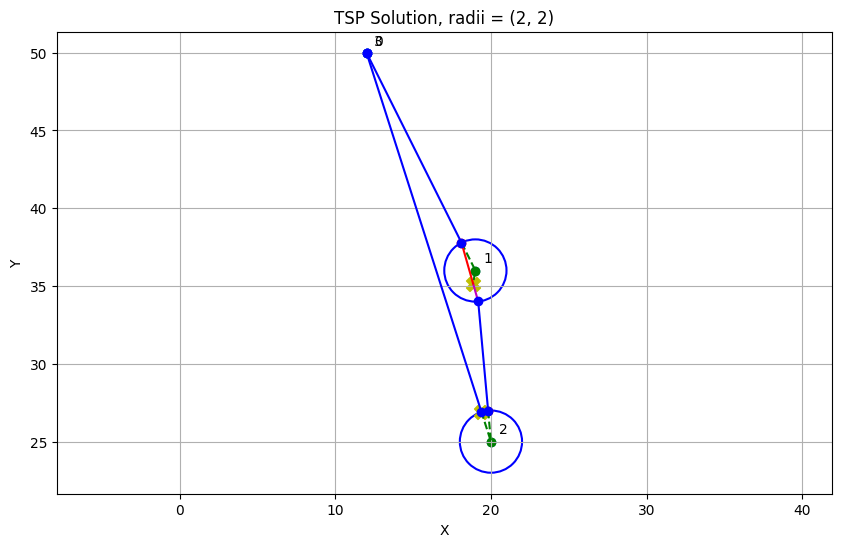

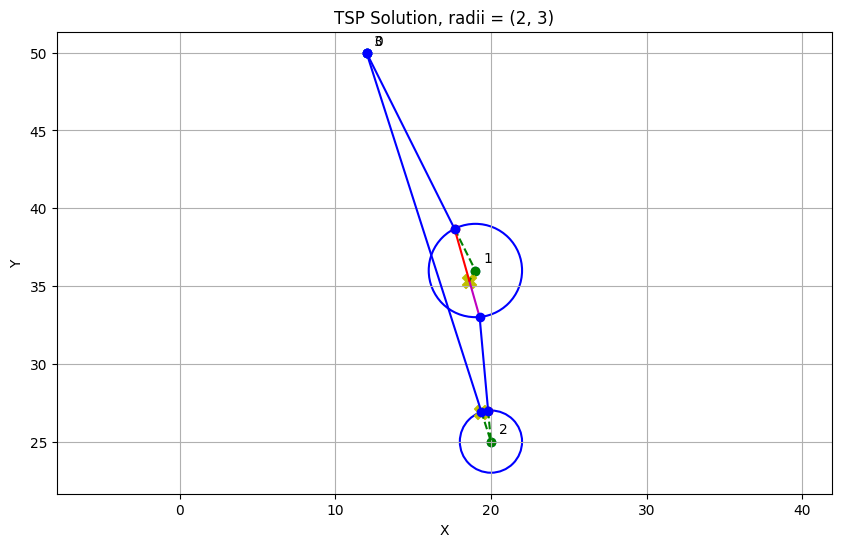

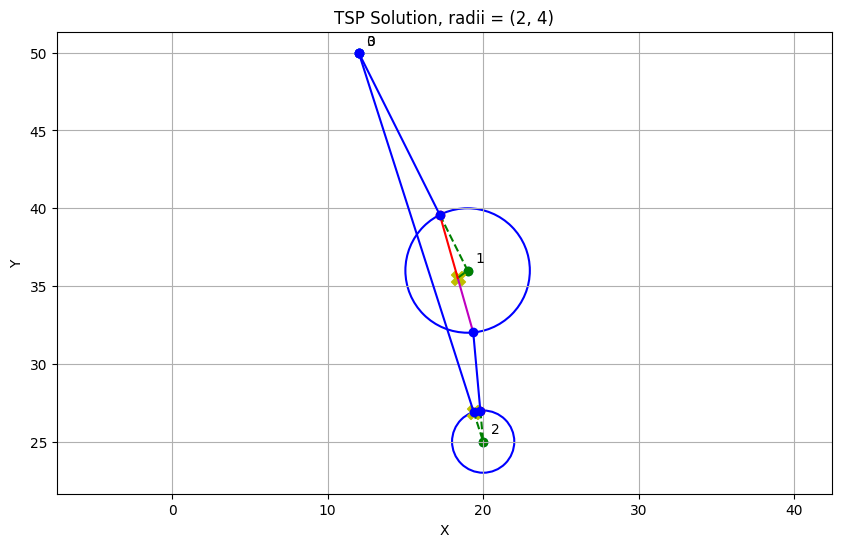

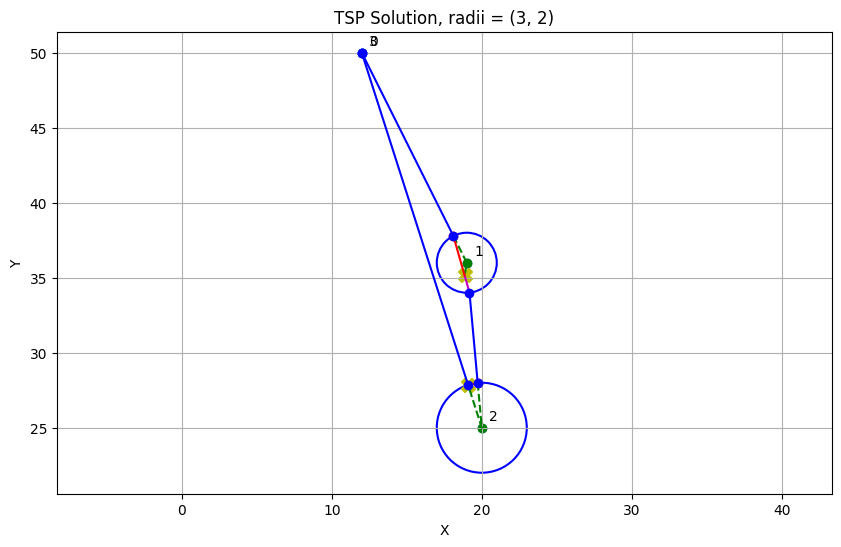

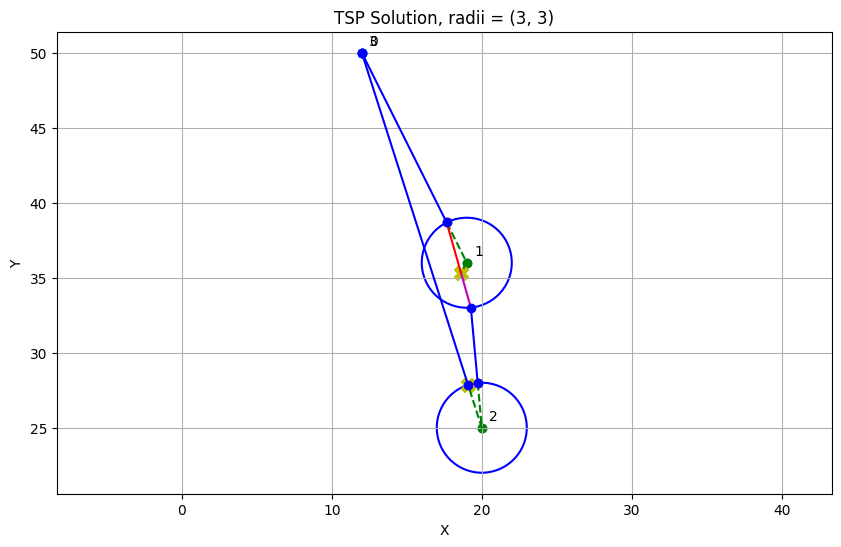

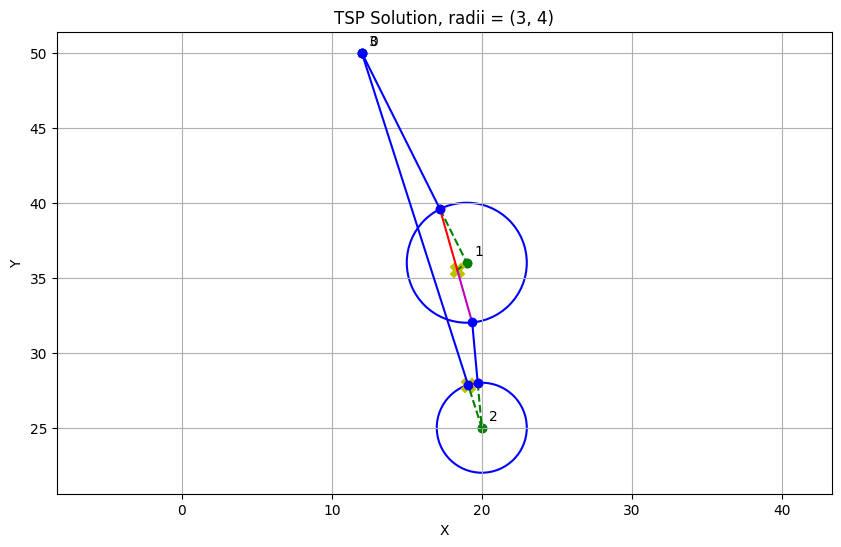

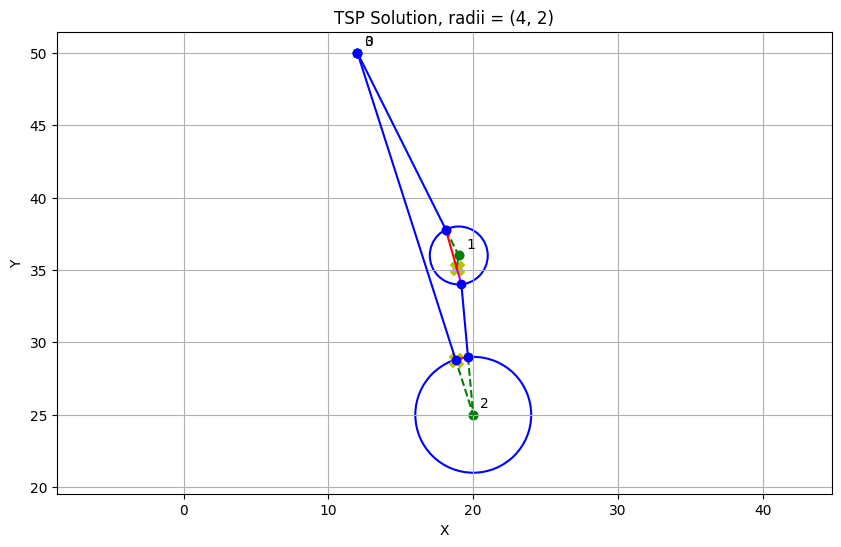

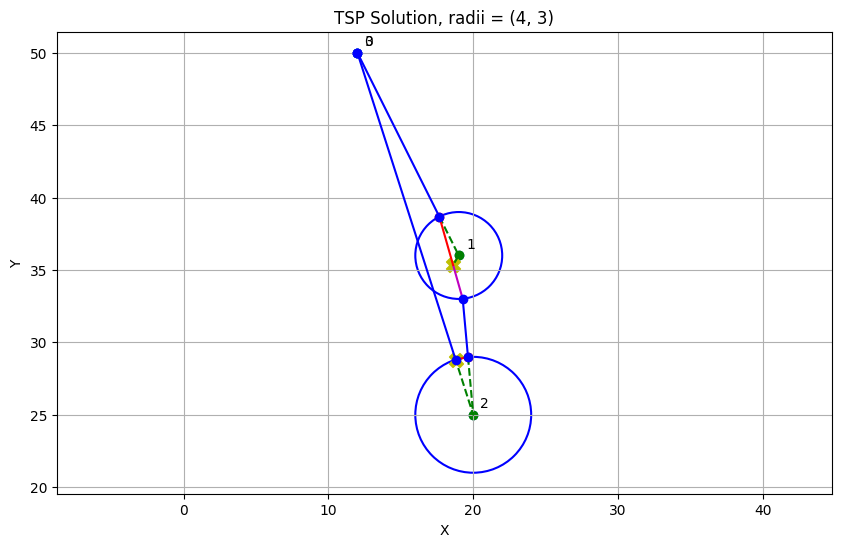

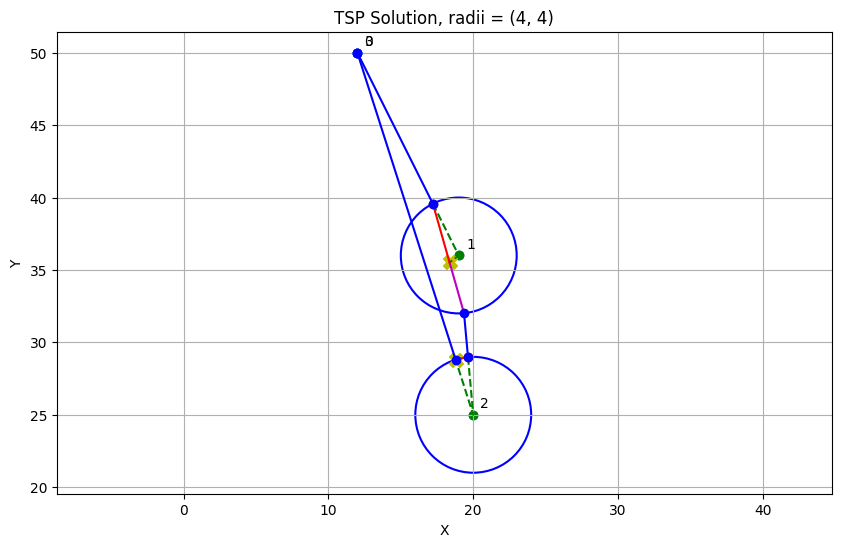

In [12]:
# Sample run again
UGVD_inter_without_drone,UGVD_inter_with_drone, UAV_distances_set, UGV_outer_path_distances= plot_solution_final_refined_v2(waypoints, plan_output, radii, speed_ugv, speed_uav, survey_time, plot_graph=True)


In [1]:
import math



# Test
c1 = (0, 0)
r1 = 5
c2 = (3, 4)
r2 = 3

print(are_circles_overlapping(c1, r1, c2, r2))  # This should return True since the circles overlap


True


In [ ]:
UGV_outer_path_distances

[['12.65', '5.05', '23.25']]

In [ ]:
UGVD_inter_without_drone

[3.4739905451423274, 0.6558162527638958]

In [ ]:
UGVD_inter_with_drone

[2.421971635426975, 0.0]

TypeError: can only concatenate list (not "float") to list

## Update edge handler 